In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
ls

 BirthData2.xlsx                         Sari_NN_byRock.ipynb
'Copie de Bienvenue dans Colaboratory'   Time_serie2.ipynb
 distplot.png                            ts.csv
 lstm1plot.png                           tsplot.png
 lstm4plot.png                           Untitled0.ipynb
 LSTM_Grid_search.ipynb                  Untitled1.ipynb
 LSTM_model.ipynb                        Untitled2.ipynb
 LSTM_model.py


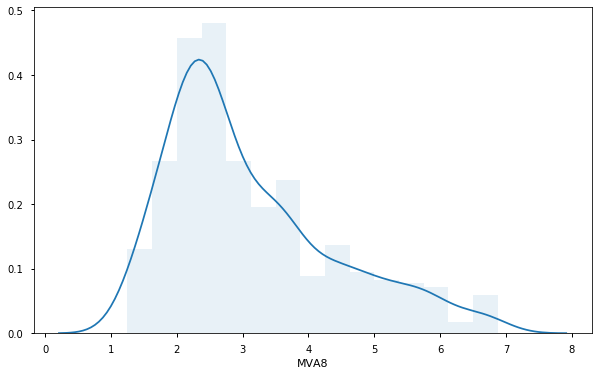

In [0]:
import numpy as np                       
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import tree
plt.style.use('seaborn-notebook')


ts=pd.read_csv("ts.csv", delimiter=',')
from datetime import datetime
con=ts['Draw.up.date']
ts['Draw.up.date']=pd.to_datetime(ts['Draw.up.date'])
ts.set_index('Draw.up.date', inplace=True)
#check datatype of index
ts.index

# weekly baseline
ts['baseline'] = ts.daily_count.shift(1)

# moving averages
ts['MVA2'] = ts.daily_count.rolling(2).mean().shift(1)
ts['MVA4'] = ts.daily_count.rolling(4).mean().shift(1)
ts['MVA6'] = ts.daily_count.rolling(6).mean().shift(1)
ts['MVA8'] = ts.daily_count.rolling(8).mean().shift(1)
ts.head(9)

ts.drop(ts.index[:8], inplace=True)
ts.head(8)

#distribution plot
plt.figure(figsize=(10, 6))
sns.distplot(ts.MVA8, hist_kws={'alpha': 0.1}, kde = True, kde_kws={'alpha': 1})
plt.savefig('lstm1plot.png')

#Define the training set
training_set = ts['MVA8'].values

training_set = training_set.reshape(-1,1)
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(training_set[0:380])
test_set_scaled= sc.fit_transform(training_set[332:449])


#Creating a data structure with 48 timesteps and 1 output
#train
X_train=[]
Y_train=[]
for i in range(48, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-48:i,0])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train=np.array(X_train), np.array(Y_train)

#test
X_test=[]
Y_test=[]
for i in range(48, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-48:i,0])
    Y_test.append(test_set_scaled[i,0])
    
X_test,Y_test=np.array(X_test),np.array(Y_test)

#Reshaping
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))




In [13]:
#Building the RNN
from sklearn import datasets
from sklearn.metrics import mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd

#initialising the RNN

def model(dropout_prop=0.2,nb_units=50,batchsize=32,epoch=100,optimizer='adam',X_train=X_train,Y_train=Y_train):
  regressor= Sequential()

  #adding the first LSTM layer and some dropout regularization
  regressor.add(LSTM(units=nb_units, return_sequences = True , input_shape=(X_train.shape[1],1)))
  regressor.add(Dropout(dropout_prop))

  #adding a third LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units=nb_units, return_sequences = True ))
  regressor.add(Dropout(dropout_prop))

  #adding a fourth LSTM layer and some Dropout regularisation
  regressor.add(LSTM(units=nb_units ))
  regressor.add(Dropout(dropout_prop))

  #adding the output layer
  regressor.add(Dense(units=1))
  #Compiling the RNN

  regressor.compile(optimizer= optimizer, loss= 'mean_squared_error')


  #Fitting the RNN to the training set
  history=regressor.fit(X_train, Y_train,validation_split=0.20, epochs=epoch, batch_size=batchsize)

  return regressor

#evaluation error

def evaluate_error(model,X_test=X_test,Y_test=Y_test):
  predicted_birth=model.predict(X_test)
  predicted_birth=sc.inverse_transform(predicted_birth)
  Y_test=sc.inverse_transform(np.array(Y_test).reshape(-1,1))
  errors = abs(predicted_birth - Y_test)
  MAE=round(np.mean(errors), 2)
  rmse =np.sqrt(mean_squared_error(Y_test,predicted_birth))
  mape = 100 * (errors / Y_test)
  MAPE=round(np.mean(mape), 2)
  return rmse



def Grid_Search(X_train=X_train,Y_train=Y_train, X_test=X_test,Y_test=Y_test):
  Result=pd.DataFrame(columns=['units','dropout_prob','batch_size','optimizer','epochs''RMSE'])
  units_matrix=[]
  dropout_prob_matrix=[]
  batch_size_matrix=[]
  optimizer_matrix=[]
  epochs_matrix=[]
  #MAE_matrix=[]
  rmse_matrix=[]
  #MAPE_matrix=[]

  units =[10,30, 50]
  dropout_rate = [0.0,0.1, 0.2]
  batch_size = [16, 32,42]
  epochs = [25,50, 100]
  optimizer = ['Adam']
  count=1
  for u in units:
    for d in dropout_rate:
      for b in batch_size:
        for o in optimizer:
          for e in epochs:
            print('evolution of the gridsearch: step ',count)
            model_regressor=model(dropout_prop=d,nb_units=u,batchsize=b,epoch=e,optimizer=o,X_train=X_train,Y_train=Y_train)
            rmse=evaluate_error(model=model_regressor,X_test=X_test,Y_test=Y_test)

            units_matrix.append(u)
            dropout_prob_matrix.append(d)
            batch_size_matrix.append(b)
            optimizer_matrix.append(o)
            epochs_matrix.append(e)
            #MAE_matrix.append(MAE)
            rmse_matrix.append(rmse)
            #MAPE_matrix.append(MAPE)
            count+=1

          
  Result['units']= units_matrix
  Result['dropout_prob']=dropout_prob_matrix
  Result['batch_size']=batch_size_matrix
  Result['optimizer']=optimizer_matrix
  Result['epochs']=epochs_matrix
  #Result['MAE']=MAE_matrix
  Result['RMSE']=rmse_matrix
  #Result['MAPE']=MAPE_matrix
  return Result

Final_Result=Grid_Search(X_train=X_train,Y_train=Y_train, X_test=X_test,Y_test=Y_test)

evolution of the gridsearch: step  1
Train on 232 samples, validate on 100 samples
Epoch 1/25
232/232 [==============================] - 56s 241ms/step - loss: 0.1323 - val_loss: 0.0626
Epoch 2/25
232/232 [==============================] - 2s 7ms/step - loss: 0.0596 - val_loss: 0.0238
Epoch 3/25
232/232 [==============================] - 2s 7ms/step - loss: 0.0423 - val_loss: 0.0241
Epoch 4/25
232/232 [==============================] - 2s 7ms/step - loss: 0.0408 - val_loss: 0.0238
Epoch 5/25
232/232 [==============================] - 2s 7ms/step - loss: 0.0369 - val_loss: 0.0235
Epoch 6/25
232/232 [==============================] - 2s 7ms/step - loss: 0.0377 - val_loss: 0.0232
Epoch 7/25
232/232 [==============================] - 2s 7ms/step - loss: 0.0354 - val_loss: 0.0231
Epoch 8/25
232/232 [==============================] - 1s 6ms/step - loss: 0.0346 - val_loss: 0.0231
Epoch 9/25
232/232 [==============================] - 1s 6ms/step - loss: 0.0336 - val_loss: 0.0234
Epoch 10/25
23

In [15]:
pd.set_option('display.max_rows', 1000)
Final_Result

,units,dropout_prob,batch_size,optimizer,epochsRMSE,epochs,RMSE
0,10,0.0,16,Adam,NaN,25,1.217429
1,10,0.0,16,Adam,NaN,50,0.771877
2,10,0.0,16,Adam,NaN,100,0.589180
3,10,0.0,32,Adam,NaN,25,1.471216
4,10,0.0,32,Adam,NaN,50,1.328195
5,10,0.0,32,Adam,NaN,100,0.642518
6,10,0.0,42,Adam,NaN,25,1.477869
7,10,0.0,42,Adam,NaN,50,1.164084
8,10,0.0,42,Adam,NaN,100,0.910721
9,10,0.1,16,Adam,NaN,25,1.292935


The best model is the one with the smallest error RMSE=0.583306 His hyperparameters are:
Units=10, dropout=0.0, batch_size=16 and epochs=100

In [0]:
#Building the RNN
from sklearn import datasets
from sklearn.metrics import mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#initialising the RNN
regressor= Sequential()

#adding the first LSTM layer and some dropout regularization
regressor.add(LSTM(units=10, return_sequences = True , input_shape=(X_train.shape[1],1)))
#regressor.add(Dropout(0.2))

#adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=10, return_sequences = True ))
#regressor.add(Dropout(0.2))

#adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=10 ))
#regressor.add(Dropout(0.2))

#adding the output layer
regressor.add(Dense(units=1))

In [20]:
#Compiling the RNN
import keras
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
regressor.compile(optimizer= 'adam', loss= 'mean_squared_error')

#Fitting the RNN to the training set
history=regressor.fit(X_train, Y_train, validation_split=0.30, epochs=100, batch_size=16, verbose=0)
history.history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [21]:
regressor.summary()

Model: "sequential_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_490 (LSTM)              (None, 48, 10)            480       
_________________________________________________________________
lstm_491 (LSTM)              (None, 48, 10)            840       
_________________________________________________________________
lstm_492 (LSTM)              (None, 10)                840       
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 11        
Total params: 2,171
Trainable params: 2,171
Non-trainable params: 0
_________________________________________________________________


In [0]:
#prediction
X_test=np.array(X_test)
X_test_shape=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_birth=regressor.predict(X_test_shape)
predicted_birth=sc.inverse_transform(predicted_birth)
Y_test=sc.inverse_transform(np.array(Y_test).reshape(-1,1))


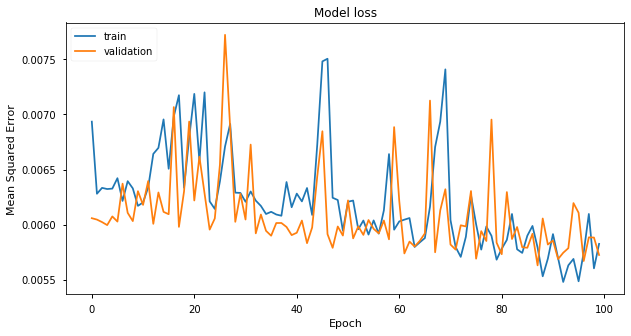

In [23]:

#epochs plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
#plt.savefig('lstm2plot.png')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


MAE on the data: 0.5000
RMSE on the data: 0.6311
MAPE on the data: 13.1000


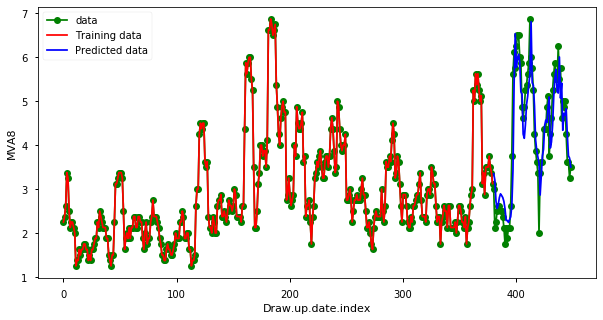

In [0]:
#vizualising result
errors = abs(predicted_birth - Y_test)
MAE=round(np.mean(errors), 2)
rmse =np.sqrt(mean_squared_error(Y_test,predicted_birth))
mape = 100 * (errors / Y_test)
MAPE=round(np.mean(mape), 2)
print('MAE on the data: %.4f' %MAE)
print('RMSE on the data: %.4f' %rmse)
print('MAPE on the data: %.4f' %MAPE)
plt.figure(figsize=(10, 5))
plt.plot(training_set,'o-',color='green',label='data')
plt.plot(range(0,380),training_set[0:380], color='red', label='Training data')
plt.plot(range(380,449) ,predicted_birth, color='blue', label='Predicted data')
plt.xlabel('Draw.up.date.index')
plt.ylabel('MVA8')
plt.legend()
#plt.savefig('lstm3plot.png')
plt.show()